In [1]:
import phoebe
import numpy as np
from spice.models.phoebe_model import PhoebeModel
from spice.spectrum import simulate_spectrum
from transformer_payne import Blackbody
from phoebe.parameters.dataset import _mesh_columns
import matplotlib.pyplot as plt
from spice.plots import plot_3D_binary

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Stromgren:b" has a newer version available.  Run phoebe.list_passband_online_history("Stromgren:b") to get a list of available changes and phoebe.update_passband("Stromgren:b") or phoebe.update_all_passbands() to update.


In [2]:
b = phoebe.default_binary()
times = np.linspace(0, 1, 10)
COLUMNS = _mesh_columns
b.set_quantity('period@binary', 1)
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.add_dataset('lc', times=times, passband='Gaia:G', dataset='lc01')
b.add_dataset('orb', compute_times=times, dataset='orb01')
b.run_compute(irrad_method='none', coordinates='uvw')

100%|██████████| 10/10 [00:00<00:00, 42.57it/s]


<ParameterSet: 639 parameters | kinds: orb, mesh, lc>

In [3]:
from spice.models.phoebe_utils import PhoebeConfig
from spice.models.binary import PhoebeBinary, evaluate_orbit
import matplotlib.pyplot as plt

bb = Blackbody()
p1 = PhoebeConfig(b, 'mesh01', 'orb01')
pb = PhoebeBinary.construct(p1, bb.parameter_names)

In [4]:
pbs = [evaluate_orbit(pb, t) for t in times]

(<Figure size 1000x1200 with 2 Axes>,
 <Axes3D: xlabel='$X [R_\\odot]$', ylabel='$Y [R_\\odot]$', zlabel='$Z [R_\\odot]$'>)

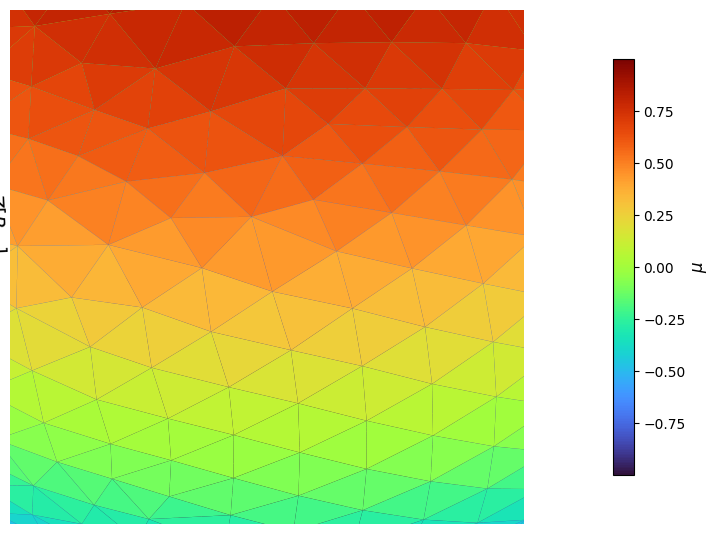

In [5]:
plot_3D_binary(pbs[0][0], pbs[0][1], property='mus',  scale_radius=1.0)

In [6]:
from spice.models.binary import evaluate_orbit


ws = np.linspace(4000, 10000, 1000)
s1s = [simulate_spectrum(bb.intensity, pb1, np.log10(ws)) for pb1, _ in pbs]
s2s = [simulate_spectrum(bb.intensity, pb2, np.log10(ws)) for _, pb2 in pbs]

In [7]:
diffs_phoebe = -2.5*np.log10(b.get_parameter('fluxes@lc01@model').value)

In [8]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import GaiaG

In [9]:
gaia_g = GaiaG()

In [10]:
lums = [AB_passband_luminosity(gaia_g, ws, s1[:, 0]+s2[:, 0]) for s1, s2 in zip(s1s, s2s)]

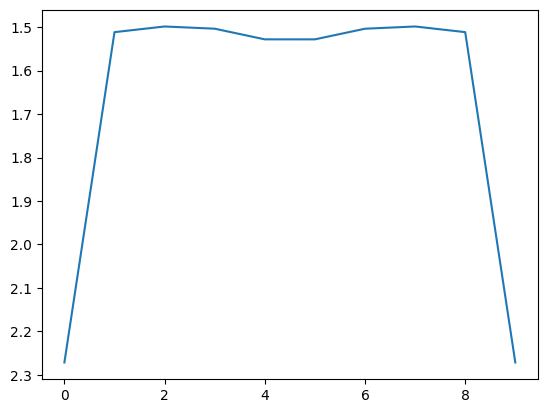

In [11]:
plt.plot(lums)
plt.gca().invert_yaxis()

In [12]:
diffs_phoebe = diffs_phoebe-diffs_phoebe[0]
diffs_spice = np.array(lums)-lums[0]

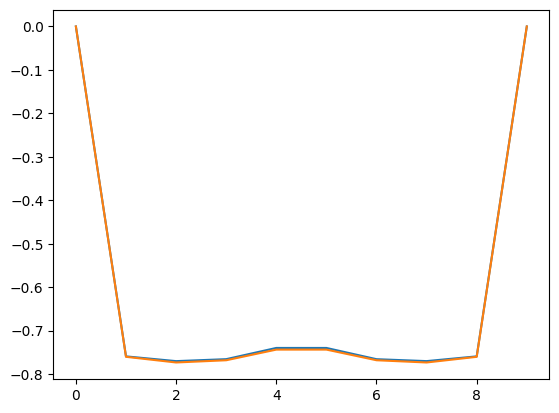

In [13]:
plt.plot(diffs_phoebe)
plt.plot(diffs_spice)

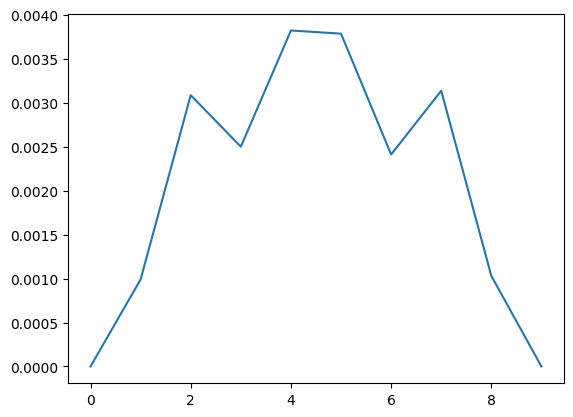

In [14]:
plt.plot(diffs_phoebe-diffs_spice)